# Clean and Balance AFIB vs SR Dataset
This notebook filters records to two groups:
- AFIB = 1 and SR = 0
- AFIB = 0 and SR = 1
Then it balances the dataset (equal counts per group), and saves the result to a new folder under `data/cleaned_balanced_AFIB_SR`.

In [1]:
# Imports and paths
from pathlib import Path
import pandas as pd
import numpy as np
import shutil
import os

ROOT = Path('.')
DATA_DIR = ROOT / 'data' / 'ecg_arrhythmia_dataset_CSV'
WFDB_DIR = DATA_DIR / 'WFDBRecords'
MAPPING_CSV = DATA_DIR / 'file_mapping.csv'
OUT_DIR = ROOT / 'data' / 'cleaned_balanced_AFIB_SR'
OUT_WFDB_DIR = OUT_DIR / 'WFDBRecords'
OUT_MAPPING_CSV = OUT_DIR / 'file_mapping_cleaned.csv'

print('Mapping CSV exists:', MAPPING_CSV.exists())
print('WFDB dir exists:', WFDB_DIR.exists())

Mapping CSV exists: True
WFDB dir exists: True


In [2]:
# Load mapping and robustly locate AFIB and SR columns
mapping = pd.read_csv(MAPPING_CSV)

def find_col(candidates):
    for c in candidates:
        if c in mapping.columns:
            return c
        for mc in mapping.columns:
            if mc.lower() == c.lower():
                return mc
    return None

afib_col = find_col(['AFIB','afib','AF'])
sr_col = find_col(['SR','sr','NORM','Normal','normal_sinus_rhythm'])

if afib_col is None or sr_col is None:
    raise RuntimeError(f'Could not find AFIB or SR column. Columns present: {list(mapping.columns)}')

def to_binary(s):
    if np.issubdtype(s.dtype, np.number):
        return (s.astype(float) > 0).astype(int)
    return s.astype(str).str.contains('AFIB|AF', case=False, na=False).astype(int)

afib = to_binary(mapping[afib_col])
sr = (mapping[sr_col].astype(int) if np.issubdtype(mapping[sr_col].dtype, np.number) else mapping[sr_col].astype(str).str.contains('SR|NORM', case=False, na=False).astype(int))

mapping['_AFIB'] = afib
mapping['_SR'] = sr
print('Counts: AFIB=1', int((mapping['_AFIB']==1).sum()), ' SR=1', int((mapping['_SR']==1).sum()))

Counts: AFIB=1 1780  SR=1 8125


In [3]:
# Filter two groups: AFIB=1 & SR=0, and AFIB=0 & SR=1
grp_afib = mapping[(mapping['_AFIB']==1) & (mapping['_SR']==0)].copy()
grp_sr = mapping[(mapping['_AFIB']==0) & (mapping['_SR']==1)].copy()
print('Group sizes -> AFIB=1/SR=0:', len(grp_afib), ' AFIB=0/SR=1:', len(grp_sr))

# Balance by downsampling the larger group
n = min(len(grp_afib), len(grp_sr))
grp_afib_bal = grp_afib.sample(n, random_state=42) if len(grp_afib)>n else grp_afib
grp_sr_bal = grp_sr.sample(n, random_state=42) if len(grp_sr)>n else grp_sr
cleaned = pd.concat([grp_afib_bal, grp_sr_bal], axis=0).sample(frac=1.0, random_state=42).reset_index(drop=True)
print('Balanced size per class:', n, ' Total:', len(cleaned))

Group sizes -> AFIB=1/SR=0: 1780  AFIB=0/SR=1: 8125
Balanced size per class: 1780  Total: 3560


In [4]:
# Prepare output folders
OUT_DIR.mkdir(parents=True, exist_ok=True)
OUT_WFDB_DIR.mkdir(parents=True, exist_ok=True)
print('Output dir:', OUT_DIR)

Output dir: data\cleaned_balanced_AFIB_SR


In [5]:
# Attempt to copy selected records/folders into OUT_WFDB_DIR
cand_cols = ['record_path','path','relative_path','wfdb_path','subdir','record','filename','file']

def resolve_src_dir(row):
    # 1) absolute/relative path column
    for c in cand_cols:
        if c in cleaned.columns and pd.notna(row.get(c, None)):
            p = Path(str(row[c]))
            if p.is_absolute():
                if p.exists():
                    return p
            else:
                rel = WFDB_DIR / p
                if rel.exists():
                    return rel
    # 2) combine subdir + record/filename
    subdir = None; record = None
    for c in ['subdir','SUBDIR','folder','FOLDER']:
        if c in cleaned.columns and pd.notna(row.get(c, None)):
            subdir = str(row[c]); break
    for c in ['record','RECORD','filename','FILENAME','file','FILE']:
        if c in cleaned.columns and pd.notna(row.get(c, None)):
            record = str(row[c]); break
    if subdir and record:
        candidate = WFDB_DIR / subdir / record
        if candidate.exists():
            return candidate
        candidate2 = WFDB_DIR / subdir
        if candidate2.exists():
            return candidate2
    # 3) Try numeric IDs forming nested dirs
    for c in cleaned.columns:
        val = row.get(c, None)
        if isinstance(val, (int, np.integer, str)) and str(val).isdigit():
            s = str(val)
            if len(s)>=3:
                candidate = WFDB_DIR / s[:2] / s
                if candidate.exists():
                    return candidate
            candidate = WFDB_DIR / s
            if candidate.exists():
                return candidate
    return None

copied = 0; missing = 0; resolved_paths = []
for _, r in cleaned.iterrows():
    src = resolve_src_dir(r)
    resolved_paths.append(src if src is not None else None)
    if src is None:
        missing += 1
        continue
    dst = OUT_WFDB_DIR / src.relative_to(WFDB_DIR)
    dst.parent.mkdir(parents=True, exist_ok=True)
    if src.is_dir():
        if not dst.exists():
            shutil.copytree(src, dst)
        copied += 1
    else:
        shutil.copy2(src, dst)
        copied += 1

cleaned['resolved_src'] = [str(p) if p is not None else '' for p in resolved_paths]
print(f'Copied {copied} records/folders. Missing paths for {missing}.')

Copied 3560 records/folders. Missing paths for 0.


In [6]:
# Save cleaned mapping CSV for reproducibility
cols_to_save = cleaned.columns.tolist()
cleaned.to_csv(OUT_MAPPING_CSV, index=False)
print('Wrote cleaned mapping to:', OUT_MAPPING_CSV)

Wrote cleaned mapping to: data\cleaned_balanced_AFIB_SR\file_mapping_cleaned.csv


## Dataset Comparison: Original vs Cleaned

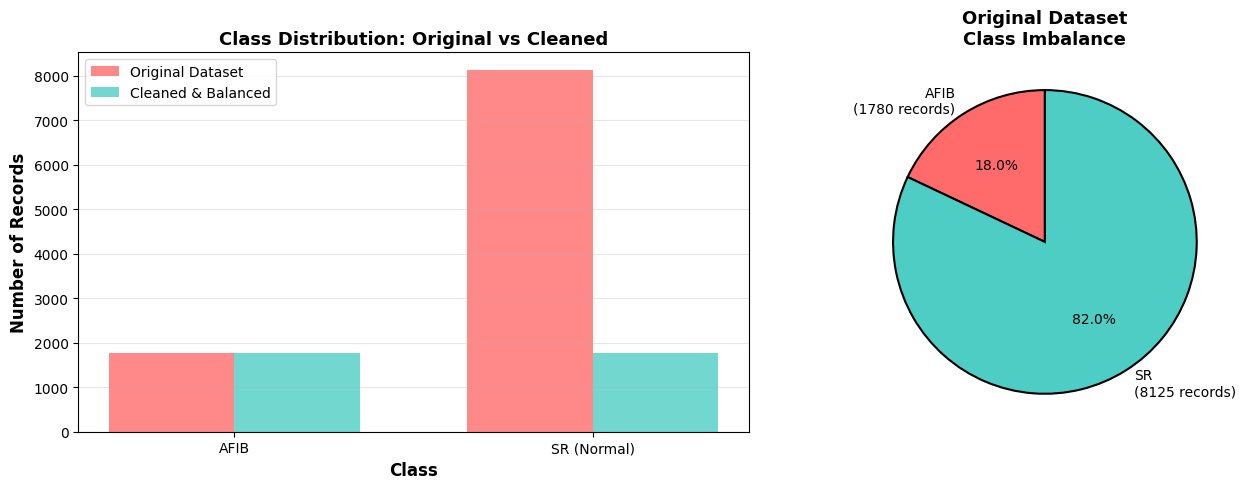


=== Dataset Comparison Summary ===
Original Dataset:
  AFIB records: 1780
  SR records: 8125
  Class ratio (SR/AFIB): 4.56:1
  Total: 9905

Cleaned & Balanced Dataset:
  AFIB records: 1780
  SR records: 1780
  Class ratio (SR/AFIB): 1.00:1
  Total: 3560

Records retained: 35.9%


In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Load cleaned dataset mapping for comparison
cleaned_mapping = pd.read_csv(OUT_MAPPING_CSV)

# Extract labels for both datasets
original_afib = mapping['_AFIB'].sum()
original_sr = mapping['_SR'].sum()
cleaned_afib = (cleaned_mapping['_AFIB']==1).sum()
cleaned_sr = (cleaned_mapping['_SR']==1).sum()

# Create figure with subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Class Distribution Comparison (Bar Chart)
categories = ['AFIB', 'SR (Normal)']
original_counts = [original_afib, original_sr]
cleaned_counts = [cleaned_afib, cleaned_sr]

x = np.arange(len(categories))
width = 0.35

axes[0].bar(x - width/2, original_counts, width, label='Original Dataset', alpha=0.8, color='#FF6B6B')
axes[0].bar(x + width/2, cleaned_counts, width, label='Cleaned & Balanced', alpha=0.8, color='#4ECDC4')
axes[0].set_xlabel('Class', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Number of Records', fontsize=12, fontweight='bold')
axes[0].set_title('Class Distribution: Original vs Cleaned', fontsize=13, fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(categories)
axes[0].legend(fontsize=10)
axes[0].grid(axis='y', alpha=0.3)

# Plot 2: Pie Charts for Class Balance
colors = ['#FF6B6B', '#4ECDC4']

# Original dataset pie
original_labels = [f'AFIB\n({original_afib} records)', f'SR\n({original_sr} records)']
axes[1].pie(original_counts, labels=original_labels, autopct='%1.1f%%', colors=colors, 
            startangle=90, textprops={'fontsize': 10}, wedgeprops={'edgecolor': 'black', 'linewidth': 1.5})
axes[1].set_title('Original Dataset\nClass Imbalance', fontsize=13, fontweight='bold')

plt.tight_layout()
plt.savefig(OUT_DIR / 'dataset_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print(f'\n=== Dataset Comparison Summary ===')
print(f'Original Dataset:')
print(f'  AFIB records: {original_afib}')
print(f'  SR records: {original_sr}')
print(f'  Class ratio (SR/AFIB): {original_sr/original_afib:.2f}:1')
print(f'  Total: {original_afib + original_sr}')
print(f'\nCleaned & Balanced Dataset:')
print(f'  AFIB records: {cleaned_afib}')
print(f'  SR records: {cleaned_sr}')
print(f'  Class ratio (SR/AFIB): {cleaned_sr/cleaned_afib:.2f}:1')
print(f'  Total: {cleaned_afib + cleaned_sr}')
print(f'\nRecords retained: {(cleaned_afib + cleaned_sr) / (original_afib + original_sr) * 100:.1f}%')


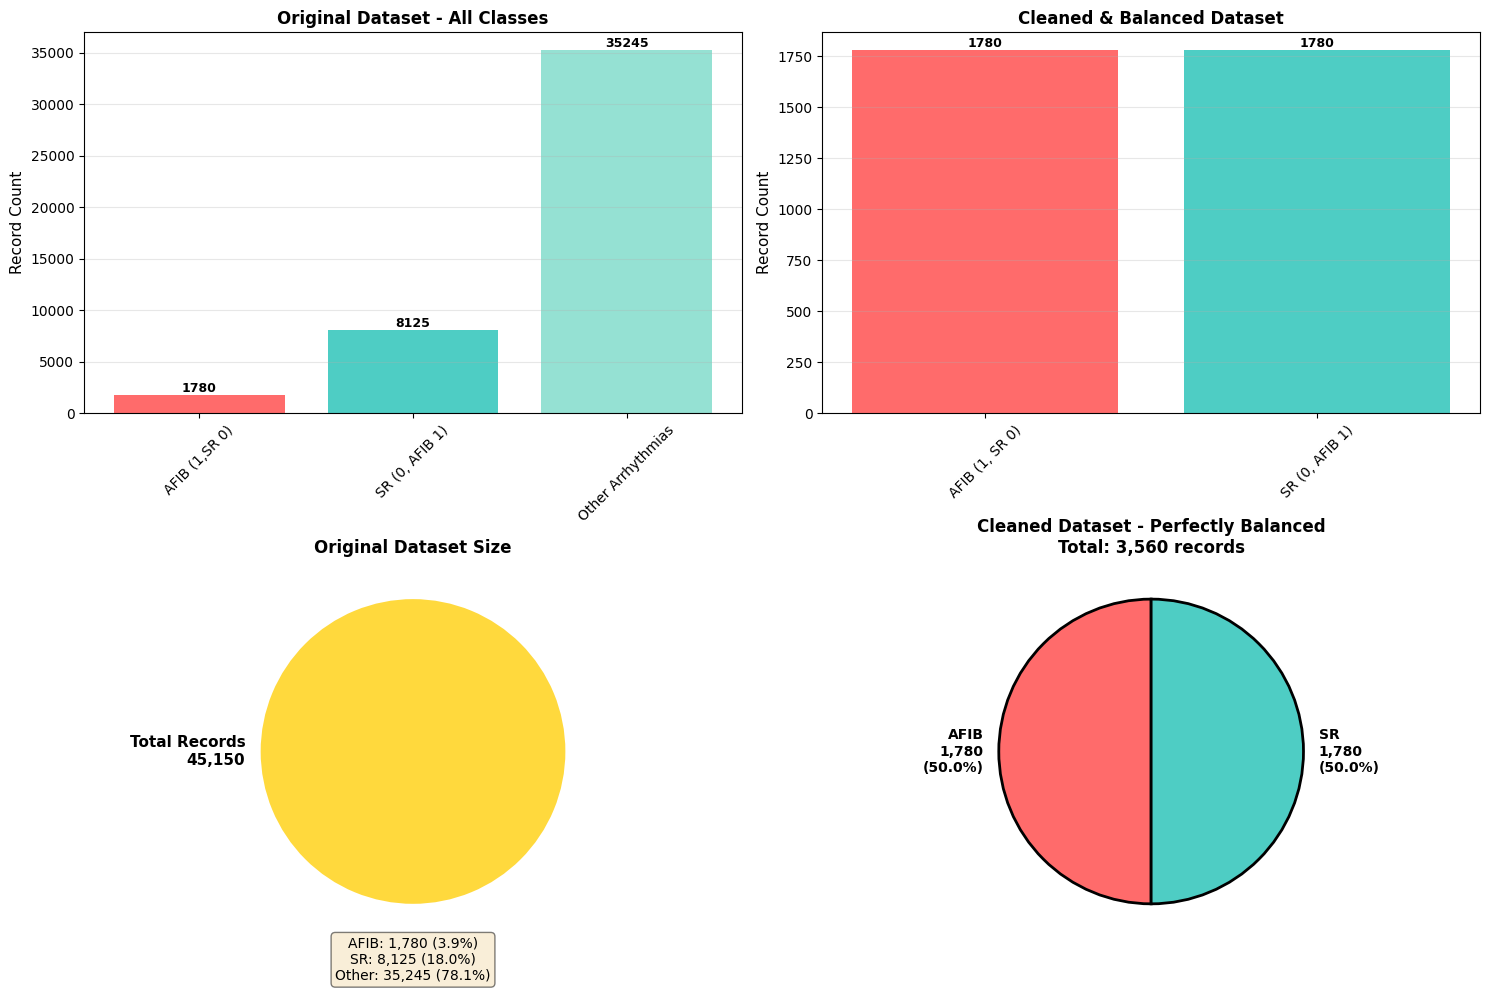

Visualizations saved to: data\cleaned_balanced_AFIB_SR


In [8]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Original dataset - Counts
ax = axes[0, 0]
original_data = pd.DataFrame({
    'Class': ['AFIB (1,SR 0)', 'SR (0, AFIB 1)', 'Other Arrhythmias', 'Unclassified'],
    'Count': [
        len(mapping[(mapping['_AFIB']==1) & (mapping['_SR']==0)]),
        len(mapping[(mapping['_AFIB']==0) & (mapping['_SR']==1)]),
        len(mapping[~(((mapping['_AFIB']==1) & (mapping['_SR']==0)) | ((mapping['_AFIB']==0) & (mapping['_SR']==1)))]),
        0
    ]
})
original_data = original_data[original_data['Count'] > 0]
bars1 = ax.bar(original_data['Class'], original_data['Count'], color=['#FF6B6B', '#4ECDC4', '#95E1D3', '#F38181'])
ax.set_title('Original Dataset - All Classes', fontsize=12, fontweight='bold')
ax.set_ylabel('Record Count', fontsize=11)
ax.tick_params(axis='x', rotation=45)
ax.grid(axis='y', alpha=0.3)
for bar in bars1:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height)}',
            ha='center', va='bottom', fontsize=9, fontweight='bold')

# Cleaned dataset - Counts (only AFIB and SR)
ax = axes[0, 1]
cleaned_data = pd.DataFrame({
    'Class': ['AFIB (1, SR 0)', 'SR (0, AFIB 1)'],
    'Count': [cleaned_afib, cleaned_sr]
})
bars2 = ax.bar(cleaned_data['Class'], cleaned_data['Count'], color=['#FF6B6B', '#4ECDC4'])
ax.set_title('Cleaned & Balanced Dataset', fontsize=12, fontweight='bold')
ax.set_ylabel('Record Count', fontsize=11)
ax.tick_params(axis='x', rotation=45)
ax.grid(axis='y', alpha=0.3)
for bar in bars2:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height)}',
            ha='center', va='bottom', fontsize=9, fontweight='bold')

# Original dataset - Pie chart
ax = axes[1, 0]
original_pie_data = [len(mapping), 0]  # total original
original_pie_labels = [f'Total Records\n{len(mapping):,}']
colors_pie = ['#FFD93D']
ax.pie([1], labels=original_pie_labels, colors=colors_pie, 
       textprops={'fontsize': 11, 'fontweight': 'bold'})
ax.set_title('Original Dataset Size', fontsize=12, fontweight='bold')

# Add text box with original composition
textstr = f'AFIB: {original_afib:,} ({original_afib/len(mapping)*100:.1f}%)\nSR: {original_sr:,} ({original_sr/len(mapping)*100:.1f}%)\nOther: {len(mapping)-original_afib-original_sr:,} ({(len(mapping)-original_afib-original_sr)/len(mapping)*100:.1f}%)'
ax.text(0, -1.5, textstr, fontsize=10, ha='center', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Cleaned dataset - Pie chart
ax = axes[1, 1]
total_cleaned = cleaned_afib + cleaned_sr
pie_data_cleaned = [cleaned_afib, cleaned_sr]
pie_labels_cleaned = [f'AFIB\n{cleaned_afib:,}\n({cleaned_afib/total_cleaned*100:.1f}%)', 
                      f'SR\n{cleaned_sr:,}\n({cleaned_sr/total_cleaned*100:.1f}%)']
ax.pie(pie_data_cleaned, labels=pie_labels_cleaned, colors=['#FF6B6B', '#4ECDC4'],
       autopct='', startangle=90, textprops={'fontsize': 10, 'fontweight': 'bold'},
       wedgeprops={'edgecolor': 'black', 'linewidth': 2})
ax.set_title(f'Cleaned Dataset - Perfectly Balanced\nTotal: {total_cleaned:,} records', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig(OUT_DIR / 'detailed_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print('Visualizations saved to:', OUT_DIR)
